In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import islpy as isl
import json



from src.qlosure.utils.isl_data_loader import json_file_to_isl
from src.qlosure.utils.isl_to_python import *
from src.qlosure.mapping.routing import POLY_QMAP
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

from src.state_of_the_art.pytket import run_pytket
from src.state_of_the_art.sabre import run_sabre
from src.state_of_the_art.qmap import run_qmap
from src.state_of_the_art.cirq import run_cirq


from qiskit import QuantumCircuit
from time import time
import warnings
warnings.filterwarnings("ignore")

In [22]:
file_path = "../benchmarks/polyhedral/queko-bss-16qbt/16QBT_100CYC_QSE_2.json"

In [23]:
data = json_file_to_isl(file_path)
edges = FakeSherbrooke().configuration().coupling_map
poly_mapper = POLY_QMAP(edges, data)
qlosure_results = poly_mapper.run(initial_mapping_method="trivial",heuristic_method="Qlosure",verbose=1)

In [24]:
data = json_file_to_isl(file_path,reschedule="min")
edges = FakeSherbrooke().configuration().coupling_map
poly_mapper = POLY_QMAP(edges, data)
qlosure_results2 = poly_mapper.run(initial_mapping_method="trivial",heuristic_method="Qlosure",verbose=1)

In [25]:
data = json_file_to_isl(file_path,reschedule="max")
edges = FakeSherbrooke().configuration().coupling_map
poly_mapper = POLY_QMAP(edges, data)
qlosure_results3 = poly_mapper.run(initial_mapping_method="trivial",heuristic_method="Qlosure",verbose=1)

In [26]:
print(f"qlosure       : {qlosure_results[0],qlosure_results[1]}")
print(f"qlosure min   : {qlosure_results2[0],qlosure_results2[1]}")
print(f"qlosure max   : {qlosure_results3[0],qlosure_results3[1]}")

qlosure       : (219, 308)
qlosure min   : (252, 382)
qlosure max   : (252, 382)


In [47]:
sabre_results = run_sabre(data,edges,layout="trivial")
cirq_results = run_cirq(data,edges,initial_mapping="trivial")
qmap_results = run_qmap(data,edges,initial_mapping="trivial")
pytket_results = run_pytket(data,edges,initial_mapping="trivial")
light_qlosure_results = poly_mapper.run(initial_mapping_method="trivial",heuristic_method="with_depth",verbose=1,param=100)
macro_results = poly_mapper.run(initial_mapping_method="trivial",heuristic_method="macro_gates",verbose=1,param=100)

In [18]:
res = run_qmap(data,edges,initial_mapping="trivial")

In [12]:
qc = res['circuit']

In [13]:
qc.count_ops()

OrderedDict([('x', 7344),
             ('cx', 2880),
             ('swap', 1644),
             ('measure', 16),
             ('barrier', 1)])

In [48]:
print(f"qlosure       : {qlosure_results[0],qlosure_results[1]}")
print(f"sabre         : {sabre_results['swap_count'],sabre_results['circuit_depth']}")
print(f"qmap          : {qmap_results['swaps'],qmap_results['depth']}")
print(f"tket          : {pytket_results['swaps'],pytket_results['depth']}")
print(f"cirq          : {cirq_results['swaps'],cirq_results['depth']}")
print(f"light qlosure : {light_qlosure_results[0],light_qlosure_results[1]}")
print(f"macro qlosure : {macro_results[0],macro_results[1]}")

qlosure       : (37, 20)
sabre         : (38, 16)
qmap          : (14, 14)
tket          : (43, 17)
cirq          : (18, 24)
light qlosure : (35, 11)
macro qlosure : (35, 11)


In [29]:
(3072-4864)*100/3072

-58.333333333333336

In [15]:
graph_data = poly_mapper.dag_full
group_dict = group_schedule(schedule.reverse())


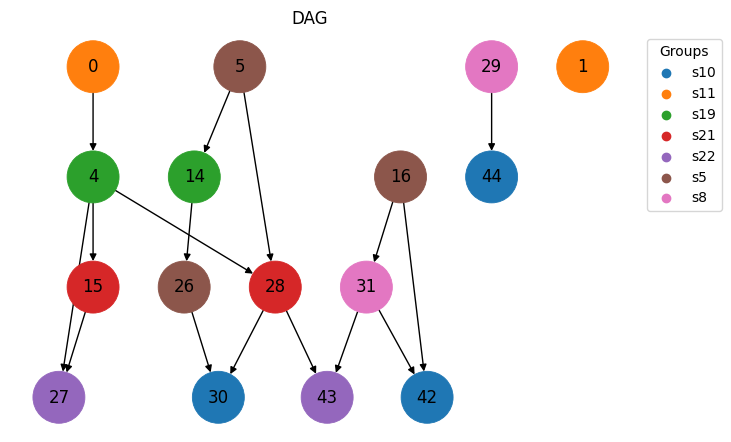

In [28]:


G = nx.DiGraph()
for u, nbrs in graph_data.items():
    for v in nbrs:
        G.add_edge(u, v)


all_nodes = set(graph_data.keys()) | {v for nbrs in graph_data.values() for v in nbrs}
for node in all_nodes:
    if node not in G:
        G.add_node(node)

pos = graphviz_layout(G, prog='dot')

all_labels = {group_dict[node][0] for node in G.nodes()}


cmap_name = 'tab10' 
cmap = plt.cm.get_cmap(cmap_name)

label_to_color = {}
for i, label in enumerate(sorted(all_labels, key=str)):
    color = cmap(i % cmap.N)
    label_to_color[label] = color

node_colors = []
for node in G.nodes():
    grp = group_dict[node][0]
    node_colors.append(label_to_color[grp])


plt.figure(figsize=(6, 4))
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_color=node_colors,
    node_size=1400,
    linewidths=0.6,
    font_size=12
)

for label, color in label_to_color.items():
    plt.scatter([], [], color=color, label=str(label))
plt.legend(title="Groups", bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.title("DAG")
plt.tight_layout()
plt.show()